# Lesson 2 - Tabular Regression and Permutation Importance

## Lesson Video:

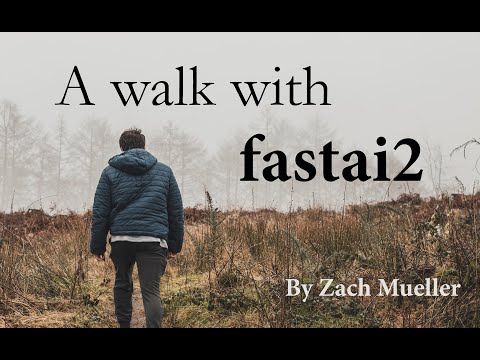

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=0, seconds=0).total_seconds())
YouTubeVideo('-aCtDIgbxMw', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.8 
---

## Rossmann

Rossmann's Kaggle competition was a business sales prediction competition for $35,000 dollars to the winners.

The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future.

We can do this through a tabular regression model.

Jeremy walks through feature engineering for this problem, for today though we will download a clean engineered dataset straight from Kaggle. To download it:
1. Go to: https://www.kaggle.com/init27/fastai-v3-rossman-data-clean
2. Go to `output`
3. Right click the download button
4. Click "copy link location" for both train and test
5. `!wget {url}`

(Note: to walk through the feature engineering, see [this](https://github.com/fastai/fastai/blob/master/nbs/course/rossman_data_clean.ipynb) notebook)

In [ ]:
train = 'ENTER_URL_HERE'
test = 'ENTER_URL_HERE'

In [ ]:
!wget {train} -q
!wget {test} -q

And now that we have our data, let's install the `fastai` library

## Time-Series Analysis

In [ ]:
from fastai.tabular.all import *

## The Data:

In [ ]:
train_df = pd.read_pickle('train_clean')
test_df = pd.read_pickle('test_clean')

In [ ]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


With our time-series based approach, the feature engineering made a bunch of date-related categorical columns that we can utilize in our **embeddings**.

In [ ]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']
   
dep_var = 'Sales'

When doing Regression with these large numbers, we often use the **log** of these values for our `y`'s. Let's transform them real quick:

In [ ]:
train_df[dep_var] = np.log(train_df[dep_var])

Now let's declare our `procs`

In [ ]:
procs = [FillMissing, Normalize, Categorify]

And splits. Now we want to ensure that (since this is time series) our validation and test 

In [ ]:
len(train_df), len(test_df)

(844338, 41088)

In [ ]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's find that particular index

In [ ]:
idx = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

In [ ]:
idx

41395

So now our `splits` will be every index *after* the 41395'th item

In [ ]:
splits = (L(range(idx, len(train_df))),L(range(idx)))

In [ ]:
splits

((#802943) [41395,41396,41397,41398,41399,41400,41401,41402,41403,41404...],
 (#41395) [0,1,2,3,4,5,6,7,8,9...])

Let's make our `TabularPandas`! Since we have a large `DataFrame`, we can enable `inplace` to `True` and `reduce_memory` to `True` to save on some storage space (**Note**: `reduce_memory` is by default `True`). To use `inplace`, we need to set `chained_assignment` to `None` in `pandas`

In [ ]:
pd.options.mode.chained_assignment=None

In [ ]:
to = TabularPandas(train_df, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                   splits=splits, inplace=True, reduce_memory=True)

And now let's build our `dataloaders`!

In [ ]:
dls = to.dataloaders(bs=512)

In [ ]:
dls.show_batch()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
0,407,3,2015,5,13,False,24,25,a,a,"Feb,May,Aug,Nov",2003,2011,BY,20,Rain-Thunderstorm,2,2,1,0,0,0,0,0,False,False,5889.999991,21.0,18.0,15.000000,88.0,68.000000,56.000000,19.000000,10.0,6.0,77.0,76.0,12.000000,-0.999998,8.433594
1,377,6,2013,11,30,False,24,25,a,c,"Feb,May,Aug,Nov",2010,2010,SH,48,Rain,5,0,0,0,0,0,0,0,False,False,100.000077,6.0,4.0,4.000000,98.0,87.000000,74.000001,21.000000,13.0,7.0,77.0,76.0,58.000000,-25.000000,9.230339
2,812,3,2015,2,4,False,24,0,d,a,#na#,2012,1900,SN,6,Snow,3,5,0,0,2,0,1,0,False,False,2589.999952,-2.0,-3.0,-4.000001,94.0,91.000000,80.000000,14.000000,10.0,6.0,62.0,66.0,34.000000,-58.000000,8.906936
3,464,4,2014,4,3,False,24,0,c,a,#na#,2009,1900,BE,14,#na#,2,4,0,0,0,0,1,0,False,True,519.999983,22.0,15.0,8.000000,82.0,58.000001,26.000000,23.000000,8.0,6.0,56.0,57.0,91.999999,-15.000000,9.067970
4,862,3,2014,8,27,False,24,25,a,c,"Jan,Apr,Jul,Oct",2010,2011,SH,35,Fog,2,2,0,0,0,2,0,0,False,False,2840.000018,22.0,13.0,5.000000,100.0,61.000001,28.000000,14.000000,6.0,2.0,75.0,77.0,79.000000,-37.000000,9.033245
5,901,6,2015,3,7,False,10,0,a,c,#na#,2014,1900,SH,10,#na#,0,5,0,0,0,0,0,0,False,False,3170.000078,13.0,9.0,4.000000,81.0,57.000000,32.000001,24.000000,14.0,8.0,57.0,64.0,65.000001,-27.000000,8.535230
6,950,5,2014,9,5,False,24,0,a,a,#na#,1994,1900,BW,36,Fog,1,5,0,0,5,5,1,1,False,False,8459.999947,24.0,18.0,12.000000,100.0,80.000000,48.000000,13.000001,3.0,3.0,65.0,62.0,78.000002,-28.000000,8.738255
7,148,1,2014,12,15,False,24,0,a,a,#na#,2008,1900,BE,51,Rain,5,1,0,0,0,0,1,0,False,False,2090.000053,6.0,3.0,1.000000,93.0,83.000000,63.000000,29.000000,14.0,6.0,78.0,79.0,73.000000,-10.000000,9.525297
8,469,3,2014,8,27,False,24,0,c,c,#na#,2005,1900,BE,35,Fog,2,2,0,0,0,2,0,0,False,False,710.000229,21.0,13.0,6.000000,94.0,62.000000,22.000001,19.000000,6.0,2.0,68.0,77.0,79.000000,-37.000000,9.122929
9,917,2,2013,10,1,False,24,0,a,a,#na#,2010,1900,NW,40,#na#,1,3,1,0,0,0,0,0,False,False,7239.999993,17.0,12.0,7.000000,81.0,64.000000,41.000000,23.000000,11.0,1.0,65.0,62.0,123.999998,-2.000002,8.837391


## The Model:


As we're doing regression, we want to dictate what the maximum value to be (and minimum) so we will use a `y_range`

In [ ]:
max_log_y = np.max(train_df['Sales'])*1.2

In [ ]:
max_log_y

12.7616122408592

And now we can make a `y_range`

In [ ]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([ 0.0000, 12.7616])

Next comes our `Learner`. We'll walk through each step

In [ ]:
learn = tabular_learner(dls, layers=[1000,500], ps=[0.001, 0.01],
                       embed_p=0.04, y_range=y_range, metrics=exp_rmspe,
                       loss_func=MSELossFlat())

So we have a lot going on right there. `ps` is overall dropout (helps with overfitting), `embed_p` is dropout on the embedding weights, `exp_rmspe` is Root Mean Square Percentage Error

Let's look at our model:

In [ ]:
learn.summary()

TabularModel (Input shape: ['512 x 26', '512 x 14'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 81             90,396     True      
________________________________________________________________
Embedding            512 x 5              40         True      
________________________________________________________________
Embedding            512 x 3              12         True      
________________________________________________________________
Embedding            512 x 7              91         True      
________________________________________________________________
Embedding            512 x 11             352        True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 10             260        True      
_____________________________________________

## Training

Now let's fit!

(0.0009120108559727668, 0.0002290867705596611)

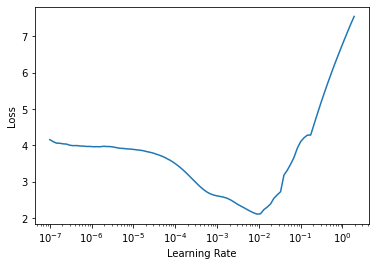

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.026195,0.026274,0.182667,00:46
1,0.015253,0.015979,0.133926,00:46
2,0.011368,0.012961,0.114459,00:47
3,0.008773,0.011173,0.109166,00:47
4,0.007508,0.010604,0.107100,00:47


For comparison, an `exp_rmspe` of 0.108 was 10th place

## Inference on a test set:
Now that we have a model, we want to make our final competitions that would be submitted to a competition, as such, we can only make the predictions and submit them as a CSV.

We'll practice bringing in an exported model just to show that you do not need the original data. 

In [ ]:
learn.export('myModel')

In [ ]:
del learn

In [ ]:
learn = load_learner('myModel')

Now we generate our `test_dl` from our `test_df`

In [ ]:
dl = learn.dls.test_dl(test_df)

We need to tell the `Learner` to return the predictions for the test set we added

In [ ]:
raw_test_preds = learn.get_preds(dl=dl)

Let's take a peek

In [ ]:
raw_test_preds

(tensor([[ 8.3808],
         [ 8.8781],
         [ 9.1845],
         ...,
         [ 8.7501],
         [10.0406],
         [ 8.9215]]), None)

You'll notice `[0]` contains our predictions, and `[1]` contains any labels (if we had any). This is nice because if we accidently run `learn.validate()` on a non-labeled test set, we get the following:

In [ ]:
learn.validate(dl=dl)

(#2) [None,None]

Still runs, just there are no labels so it's `None`

Now back to our predictions! We need to undo our `log` transform first:

In [ ]:
np.exp(raw_test_preds[0])

tensor([[ 4362.4321],
        [ 7173.3774],
        [ 9745.0059],
        ...,
        [ 6311.3501],
        [22939.8164],
        [ 7490.9766]])

In [ ]:
test_preds = np.exp(raw_test_preds[0]).numpy().T[0]

(If you want to learn about what `T` does, compare below):

In [ ]:
raw_test_preds[0].numpy()

array([[ 8.380785],
       [ 8.878132],
       [ 9.18451 ],
       ...,
       [ 8.750105],
       [10.040629],
       [ 8.921454]], dtype=float32)

In [ ]:
test_preds

array([ 4362.432 ,  7173.3774,  9745.006 , ...,  6311.35  , 22939.816 ,
        7490.9766], dtype=float32)

Now we can submit to Kaggle!

In [ ]:
test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

And finally we make our submission. **NOTE:** remove the index when generating your submission always!

In [ ]:
test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)

## Permutation Importance

Permutation importance is a technique in which we shuffle each column in a dataframe and analyze how changing a particular column affected our `y` values. The more that it was affected, the more "important" we can (generally) call a variable in our neural network. Let's build a quick algorithm to do this:

In [ ]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

And now we can simply call `PermutationImportance` to run it!

Getting base error


Calculating Permutation Importance


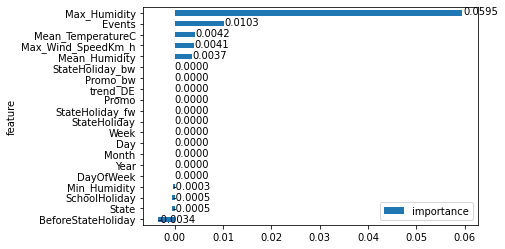

In [ ]:
res = PermutationImportance(learn, train_df.iloc[:1000], bs=64)

In [ ]:
res.importance

{'AfterStateHoliday': -0.006495955086819835,
 'Assortment': -0.15894991142484757,
 'BeforeStateHoliday': -0.0034450730077863977,
 'CloudCover': -0.021922465471671267,
 'CompetitionDistance': -0.07073883242654737,
 'CompetitionMonthsOpen': -0.048707575175682846,
 'CompetitionOpenSinceYear': -0.006830320781063511,
 'Day': 0.0,
 'DayOfWeek': 0.0,
 'Events': 0.010310428429607058,
 'Max_Humidity': 0.05946607822128924,
 'Max_TemperatureC': -0.029806386487200524,
 'Max_Wind_SpeedKm_h': 0.004062584161248675,
 'Mean_Humidity': 0.0036539491262186446,
 'Mean_TemperatureC': 0.0041852054038987,
 'Mean_Wind_SpeedKm_h': -0.017164310518782103,
 'Min_Humidity': -0.0003381559916355307,
 'Min_TemperatureC': -0.012325842237373623,
 'Month': 0.0,
 'Promo': 0.0,
 'Promo2SinceYear': -0.026129080933810448,
 'Promo2Weeks': -0.3059371320786493,
 'PromoInterval': -0.11177023585996265,
 'Promo_bw': 0.0,
 'Promo_fw': -0.0034969078856317715,
 'SchoolHoliday': -0.00045760157971400057,
 'SchoolHoliday_bw': -0.0616699